# Sampling $C_\ell$ spectra from Planck data

Strategy: Use Planck lite data and data covariance.

To consider: Use Planck lite covmat with full Planck means?

In [39]:
import os
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import FortranFile
from collections import namedtuple

In [40]:
height = 2
fontsize = 11/1.2
cm = 1/2.54  # centimeters in inches
width = 8.6*cm # PRL figure width
matplotlib.rcParams.update({
    'font.size'          : fontsize,
    'mathtext.fontset'   : 'cm',
})
Hubbles_to_Gyr = 0.001022

### Load Planck lite data
Broadly copied from https://github.com/heatherprince/planck-lite-py/blob/master/planck_lite_py.py

In [70]:
class PlanckDataSampler:
    SamplesTuple = namedtuple('SamplesTuple', ['tt', 'te', 'ee'])

    def __init__(self):
        self.calPlanck=1

        self.nbintt_hi = 215 #30-2508   #used when getting covariance matrix
        self.nbinte = 199 #30-1996
        self.nbinee = 199 #30-1996
        self.nbin_hi=self.nbintt_hi+self.nbinte+self.nbinee

        self.data_dir = '../data/planck2018_plik_lite/'
        self.cov_file = os.path.join(self.data_dir, 'c_matrix_plik_v22.dat')
        self.like_file = os.path.join(self.data_dir, 'cl_cmb_plik_v22.dat')
        self.blmin_file = os.path.join(self.data_dir, 'blmin.dat')
        self.blmax_file = os.path.join(self.data_dir, 'blmax.dat')
        self.binw_file = os.path.join(self.data_dir, 'bweight.dat')
        
        self.bval, self.X_data, self.X_sig=np.genfromtxt(self.like_file, unpack=True)
        self.blmin=np.loadtxt(self.blmin_file).astype(int)
        self.blmax=np.loadtxt(self.blmax_file).astype(int)
        self.bin_w=np.loadtxt(self.binw_file)

        self.nbintt=self.nbintt_hi
        self.nbin_tot=self.nbintt+self.nbinte+self.nbinee

        self.Dl_tt = self.X_data[:self.nbintt]
        self.l_tt = self.bval[:self.nbintt]
        self.Cl_tt = self.Dl_tt*self.l_tt*(self.l_tt + 1)/(2*np.pi)
        self.Dl_te = self.X_data[self.nbintt:self.nbintt+self.nbinte]
        self.l_te = self.bval[self.nbintt:self.nbintt+self.nbinte]
        self.Cl_te = self.Dl_te*self.l_te*(self.l_te + 1)/(2*np.pi)
        self.Dl_ee = self.X_data[self.nbintt+self.nbinte:]
        self.l_ee = self.bval[self.nbintt+self.nbinte:]
        self.Cl_ee = self.Dl_ee*self.l_ee*(self.l_ee + 1)/(2*np.pi)

        #read full covmat
        f = FortranFile(self.cov_file, 'r')
        covmat = f.read_reals(dtype=float).reshape((self.nbin_hi,self.nbin_hi))
        for i in range(self.nbin_hi):
            for j in range(i,self.nbin_hi):
                covmat[i,j] = covmat[j,i]

        # Assume always both TT, TE and EE
        bin_no=self.nbin_hi
        self.cov = covmat

        """
            covmat trouble: it is positive definite, and can be inverted
            but its determinant comes out as zero since its diagonal entries are very small

            so scipy.stats.multivariate_normal complains, probably because of this
            but apparently np.random.multivariate_normal works :) 
        
        """
        
    def sample(self, size=1, sigma_scale=1):
        samples = np.random.multivariate_normal(
            mean=np.concatenate([self.Cl_tt, self.Cl_te, self.Cl_ee]), 
            cov=self.cov*sigma_scale,
            size=size
        )
        return self.SamplesTuple(tt=samples[:,:self.nbintt], te=samples[:,self.nbintt:self.nbintt+self.nbinte], ee=samples[:,self.nbintt+self.nbinte:])


sampler = PlanckDataSampler()

In [53]:
print(np.array(sampler.X_data).shape)
print(sampler.cov.shape)
#print(sampler.bval)

(613,)
(613, 613)


### Plot of data means

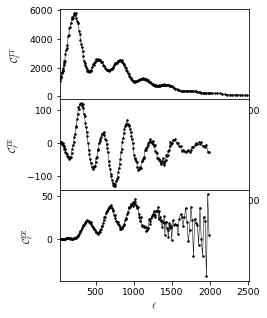

In [54]:
llim = [28, 2506]
marks = 3
lws=0.5

fig, ax = plt.subplots(3, 1, figsize=(width, 2.5*height))
ax[0].set(xticks=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1].set(xticks=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2].set(xlabel=r'$\ell$', ylabel=r'$\mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
ax[0].plot(sampler.l_tt, sampler.Cl_tt, 'k.-', ms=marks, lw=lws)
ax[1].plot(sampler.l_te, sampler.Cl_te, 'k.-', ms=marks, lw=lws)
ax[2].plot(sampler.l_ee, sampler.Cl_ee, 'k.-', ms=marks, lw=lws)

fig.subplots_adjust(hspace=0)

# Drawing spectra from covmat

In [75]:
N = 250
samples = sampler.sample(N, sigma_scale=5)

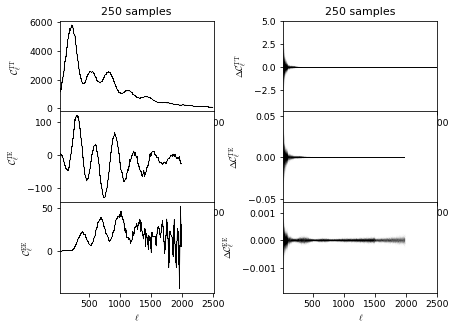

In [81]:
llim = [28, 2506]
marks = 3
lws=0.5
sample_ls = 0.05
sample_alpha = 0.1

fig, ax = plt.subplots(3, 2, figsize=(2*width, 2.5*height))
ax[0,0].set_title(f'{N} samples')
ax[0,0].set(xticks=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,0].set(xticks=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,0].set(xlabel=r'$\ell$', ylabel=r'$\mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
ax[0,0].plot(sampler.l_tt, sampler.Cl_tt, 'k-', ms=marks, lw=lws)
ax[1,0].plot(sampler.l_te, sampler.Cl_te, 'k-', ms=marks, lw=lws)
ax[2,0].plot(sampler.l_ee, sampler.Cl_ee, 'k-', ms=marks, lw=lws)
ax[0,1].set_title(f'{N} samples')
ax[0,1].set(xticks=[], ylabel=r'$\Delta \mathcal{D}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,1].set(xticks=[], ylabel=r'$\Delta  \mathcal{D}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,1].set(xlabel=r'$\ell$', ylabel=r'$\Delta \mathcal{D}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
for idx in range(N):
    ax[0,0].plot(sampler.l_tt, samples.tt[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[1,0].plot(sampler.l_te, samples.te[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[2,0].plot(sampler.l_ee, samples.ee[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[0,1].plot(sampler.l_tt, samples.tt[idx] - sampler.Cl_tt, 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[1,1].plot(sampler.l_te, samples.te[idx] - sampler.Cl_te, 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[2,1].plot(sampler.l_ee, samples.ee[idx] - sampler.Cl_ee, 'k-', lw=sample_ls, alpha=sample_alpha)

fig.subplots_adjust(hspace=0, wspace=0.45)
fig.savefig('samples.pdf')

High-ell Dl_EE looks very shaky. Planck paper shows only Cl for EE, and without the ell factors in Dl, it doesn't look as bad. 

The noise in high-ell Dl is a problem, since it means we will get unphysical spectra.